In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from multiprocessing import Pool
import warnings

warnings.filterwarnings("ignore")

os.chdir('../../..')

In [2]:
#loaded = np.load('./Generated/Spectrums/psds_array_morlet.npz')
loaded = np.load('./Generated/Spectrums/psds_array_morlet.npz')

results_arr = []

i = 0
while f'psd_{i}' in loaded:
    psd = loaded[f'psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age])
    i += 1

psd, s_id, t_id, gender, handiness, age = results_arr[0]
psd.shape

(63, 80)

In [3]:
# Parse into two lists will be used furthere
psds_array = [item[0] for item in results_arr]
psds_array = np.array(psds_array)                            # Convert list of PSDs to a numpy array
psds_array = psds_array.reshape((psds_array.shape[0], -1))   # Vectorize 

metadata = [item[1:] for item in results_arr]

psds_array.shape

(31, 5040)

In [4]:
file_path = r'./Supplementary/Experiment_Metadata.xlsx'
meta = pd.read_excel(file_path, header=1).rename(columns={
    'Subject ID'          : 'Subject_id',
    'Время начала записи' : 'Time',
})

meta['Subject_id'] = (
    meta['Subject_id']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)
    .astype('float')
)
meta = meta[meta['Subject_id'].notna()].copy()
meta['Subject_id'] = meta['Subject_id'].astype(int)

s  = meta['Time'].astype(str).str.strip()                    
n  = pd.to_numeric(s, errors='coerce')                        
dt_str = pd.to_datetime(s, errors='coerce', dayfirst=True, infer_datetime_format=True)
dt_num = pd.to_datetime(n, errors='coerce', origin='1899-12-30', unit='D')
dt = dt_str.fillna(dt_num)                                   

meta['Hour'] = dt.dt.hour
meta['Time'] = dt.dt.strftime('%H:%M')

meta_idx = (meta[['Subject_id', 'Hour', 'Time']]
            .dropna(subset=['Hour'])                         
            .drop_duplicates('Subject_id', keep='last'))

m = np.array(metadata, dtype=object)  # [s_id, t_id, gender, handiness, age]
df_out = pd.DataFrame({'Subject_ID': m[:,0].astype(int), 'Trial_ID': m[:,1].astype(int)})
df_out = df_out.merge(meta_idx, left_on='Subject_ID', right_on='Subject_id', how='left').drop(columns=['Subject_id'])

df_out['Condition'] = pd.cut(
    df_out['Hour'],
    bins=[-0.1, 10, 18, 24],
    labels=['Other', 'Day', 'Evening'],
    right=False,
    include_lowest=True
).astype(object).fillna('Other')

df_out = df_out[['Subject_ID', 'Trial_ID', 'Time', 'Condition']]

print(df_out['Condition'].value_counts(dropna=False))
df_out.head(10)

Condition
Day        17
Evening    14
Name: count, dtype: int64


,Subject_ID,Trial_ID,Time,Condition
0,4,2,16:00,Day
1,4,1,16:00,Day
2,14,1,13:00,Day
3,15,2,16:00,Day
4,15,1,16:00,Day
5,1,2,18:00,Evening
6,1,1,18:00,Evening
7,5,2,19:00,Evening
8,5,1,19:00,Evening
9,3,2,13:00,Day


In [5]:
def map_cond(c):
    if pd.isna(c): return None
    if c == 'Day': return 'Day'
    if c == 'Evening': return 'Night'
    if c == 'Night': return 'Night'
    return None  

mapped = df_out['Condition'].apply(map_cond)

row_choice = pd.Series(mapped).where(pd.Series(mapped).notna())
mode_global = pd.Series([x for x in row_choice if pd.notna(x)]).mode().iloc[0] if pd.Series(row_choice).notna().any() else 'Day'

subj_choice = (df_out
    .assign(_choice=row_choice)
    .sort_values(['Subject_ID','Trial_ID'])
    .groupby('Subject_ID', as_index=False)['_choice']
    .agg(lambda s: next((x for x in s if pd.notna(x)), mode_global))
    .rename(columns={'_choice':'Cond_final'})
)
subj2cond = dict(zip(subj_choice['Subject_ID'], subj_choice['Cond_final']))
df_out['Cond_final'] = df_out['Subject_ID'].map(subj2cond)

print('Counts by subject condition:', pd.Series(subj2cond).value_counts().to_dict())
print(df_out['Cond_final'].value_counts(dropna=False))


first_psd = results_arr[0][0]
n_channels, n_freqs = first_psd.shape

day_vectors   = {ch: [] for ch in range(n_channels)}
night_vectors = {ch: [] for ch in range(n_channels)}
placed = {'Day': 0, 'Night': 0}

for psd, s_id, t_id, gender, handiness, age in results_arr:
    cond = subj2cond.get(int(s_id), mode_global)
    if cond == 'Day':
        for ch in range(n_channels):
            day_vectors[ch].append(psd[ch, :].astype(float))
        placed['Day'] += 1
    else:
        for ch in range(n_channels):
            night_vectors[ch].append(psd[ch, :].astype(float))
        placed['Night'] += 1

print('Placed trials:', placed)

day_matrices   = {ch: (np.vstack(v) if v else np.empty((0, n_freqs))) for ch, v in day_vectors.items()}
night_matrices = {ch: (np.vstack(v) if v else np.empty((0, n_freqs))) for ch, v in night_vectors.items()}

for ch in range(min(5, n_channels)):
    print(f'ch {ch}: day_matrix={day_matrices[ch].shape}, night_matrix={night_matrices[ch].shape}')

Counts by subject condition: {'Day': 9, 'Night': 7}
Cond_final
Day      17
Night    14
Name: count, dtype: int64
Placed trials: {'Day': 17, 'Night': 14}
ch 0: day_matrix=(17, 80), night_matrix=(14, 80)
ch 1: day_matrix=(17, 80), night_matrix=(14, 80)
ch 2: day_matrix=(17, 80), night_matrix=(14, 80)
ch 3: day_matrix=(17, 80), night_matrix=(14, 80)
ch 4: day_matrix=(17, 80), night_matrix=(14, 80)


In [6]:
# Welch t-test 
from scipy import stats
from statsmodels.stats.power import TTestIndPower

n_freqs = day_matrices[0].shape[1]  # количество частот из первого канала
#freqs = np.arange(n_freqs, dtype=float)
freqs = np.linspace(2, 40, 40*2)

power_calc = TTestIndPower()
alpha = 0.05

def effect_size_d(x, y):
    # Cohen's d: разница средних / std
    nx, ny = len(x), len(y)
    sp = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / sp


rows = []
for ch, D in day_matrices.items():
    N = night_matrices.get(ch, None)

    n_freqs = D.shape[1]
    for fi in range(n_freqs):
        x = D[:, fi]
        y = N[:, fi]

        # Welch t-test
        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')

        # Power — через effect size
        d = effect_size_d(x, y)
        n1, n2 = len(x), len(y)
        ratio = n2 / n1 
        power = power_calc.solve_power(effect_size=np.abs(d), nobs1=n1, ratio=ratio,
                                           alpha=alpha, alternative='two-sided')
        i = True

        
        rows.append({
            "channel": ch,
            "freq_hz": float(freqs[fi]),
            "n_day": len(x),
            "n_night": len(y),
            "t_stat": float(t),
            "p_value": float(p),
            "power": float(power),
            "Hyp": bool(i) if power > p else not i
        })

welch_df = pd.DataFrame(rows).sort_values(["p_value", "channel", "freq_hz"])
print(welch_df.head(15))

      channel    freq_hz  n_day  n_night    t_stat   p_value     power   Hyp
1248       15  25.088608     17       14  3.813698  0.001155  0.923115  True
1249       15  25.569620     17       14  3.811613  0.001167  0.922694  True
1247       15  24.607595     17       14  3.804396  0.001173  0.922097  True
1250       15  26.050633     17       14  3.801488  0.001200  0.921250  True
1246       15  24.126582     17       14  3.780980  0.001229  0.919248  True
1251       15  26.531646     17       14  3.787449  0.001244  0.919282  True
1252       15  27.012658     17       14  3.773864  0.001288  0.917340  True
1259       15  30.379747     17       14  3.789747  0.001297  0.918178  True
1258       15  29.898734     17       14  3.785639  0.001303  0.917751  True
1260       15  30.860759     17       14  3.786575  0.001308  0.917707  True
1257       15  29.417722     17       14  3.777675  0.001319  0.916864  True
1253       15  27.493671     17       14  3.764285  0.001323  0.915896  True

In [7]:
bands = {
    'Delta': (1, 4),
    'Tetta': (4, 7),
    'Alpha': (7, 13),
    'Beta': (13, 30)
}

band_rows = []


band_idx = {b: np.where((freqs >= lo) & (freqs < hi))[0] for b,(lo,hi) in bands.items()}

for ch, D in day_matrices.items():
    N = night_matrices.get(ch, np.empty((0, len(freqs))))
    if D.size == 0 or N.size == 0:
        continue
    for b, idx in band_idx.items():
        if len(idx) == 0:
            continue
        x = np.nanmean(D[:, idx], axis=1)  # средняя мощность в диапазоне по записи
        y = np.nanmean(N[:, idx], axis=1)

        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
        d = effect_size_d(x, y)
        try:
            n1, n2 = len(x), len(y)
            ratio = n2 / n1 if n1 > 0 else 1.0
            power = power_calc.solve_power(effect_size=np.abs(d), nobs1=n1, ratio=ratio,
                                           alpha=alpha, alternative='two-sided')
        except Exception:
            power = np.nan
        i = True
        band_rows.append({
            "channel": ch,
            "band": b,
            "n_day": len(x),
            "n_night": len(y),
            "t_stat": float(t),
            "p_value": float(p),
            "power": float(power) if np.isfinite(power) else np.nan,
            "mean_day": float(np.nanmean(x)),
            "mean_night": float(np.nanmean(y)),
            "HYP": bool(i) if  p <= 0.01 else not i
        })
band_df = pd.DataFrame(band_rows).sort_values(["p_value", "power"])
print(band_df.head(15))
from pathlib import Path
outdir = Path(file_path).parent  # куда класть (рядом с Excel)
band_df.to_csv(outdir / "band_stats_morlet_all.csv", index=False)
band_df.to_excel(outdir / "band_stats_morlet_all.xlsx", index=False)


     channel  band  n_day  n_night    t_stat   p_value     power  mean_day  \
247       61  Beta     17       14  2.904467  0.008358  0.741164  0.063045   
63        15  Beta     17       14  2.772606  0.010116  0.721498  0.085475   
115       28  Beta     17       14  2.785656  0.011608  0.697615  0.095189   
159       39  Beta     17       14  2.687441  0.013128  0.680999  0.074711   
7          1  Beta     17       14  2.724221  0.014056  0.671109  0.072493   
35         8  Beta     17       14  2.670748  0.014657  0.663568  0.176425   
243       60  Beta     17       14  2.554271  0.020017  0.615829  0.102106   
127       31  Beta     17       14  2.341779  0.030267  0.547061  0.235888   
11         2  Beta     17       14  2.250758  0.036898  0.512625  0.128427   
43        10  Beta     17       14  2.211541  0.036984  0.517800  0.075780   
131       32  Beta     17       14  2.142663  0.047197  0.468498  0.128200   
83        20  Beta     17       14  2.074713  0.047745  0.481780

In [8]:
path = "./Generated/Data/S_1/Trial_1/EEG_clean.fif"  # замените на свой путь


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    raw = mne.io.read_raw_fif(path, preload=True, verbose=False)


raw.pick_types(eeg=True)

eeg = raw

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [9]:
import warnings, math, numpy as np, mne
import matplotlib.pyplot as plt
from pathlib import Path

# --- загрузка и подготовка ---
path = './Generated/Data/S_1/Trial_1/EEG_clean.fif'  # твой путь

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    raw = mne.io.read_raw_fif(path, preload=True, verbose=False)

eeg = raw.copy().pick_types(eeg=True)        # оставляем только EEG
ch_names = eeg.info['ch_names']


eeg.set_montage('standard_1020', on_missing='warn', match_case=False)



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


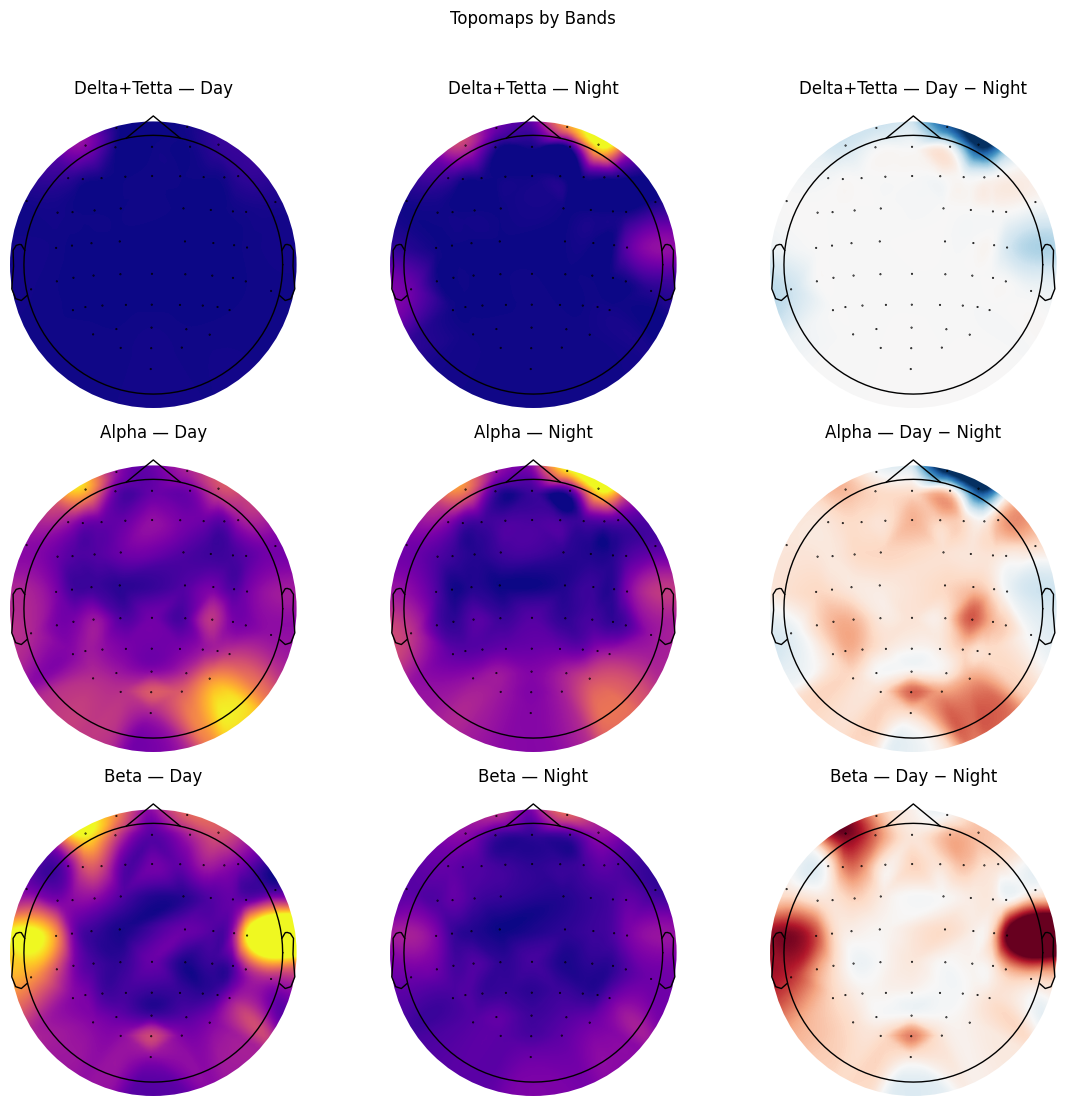

In [10]:

import numpy as np
import mne
import matplotlib.pyplot as plt
from pathlib import Path

info       = eeg.info
ch_names   = info['ch_names']
n_channels = len(ch_names)


band_limits = {
    'Delta+Tetta': (1, 7),
    'Alpha': (7, 13),
    'Beta':  (13, 30),
}


channels_to_show = [15]


if 'freqs' not in globals():
    any_ch = next((k for k,v in (day_matrices | night_matrices).items() if v.size), None)
    nF = day_matrices.get(any_ch, night_matrices.get(any_ch)).shape[1]
    freqs = np.linspace(1, 40, nF)

def band_idx(freqs, fmin, fmax):
    
    return np.where((freqs >= fmin) & (freqs <= fmax))[0]

def mean_over_band(mat, idx):
    
    if mat.size == 0 or idx.size == 0:
        return np.nan
    return float(np.nanmean(np.nanmean(mat[:, idx], axis=1)))

def build_maps(dayM, nightM, freqs, fmin, fmax, n_channels):
    idx = band_idx(freqs, fmin, fmax)
    day   = np.full(n_channels, np.nan, float)
    night = np.full(n_channels, np.nan, float)
    for ch in range(n_channels):
        D = dayM.get(ch,   np.empty((0, len(freqs))))
        N = nightM.get(ch, np.empty((0, len(freqs))))
        if D.size and D.shape[1] == len(freqs):
            day[ch]   = mean_over_band(D, idx)
        if N.size and N.shape[1] == len(freqs):
            night[ch] = mean_over_band(N, idx)
    return day, night, (day - night), idx

def vlim_pair(a, b):
    lo = np.nanmin([np.nanmin(a), np.nanmin(b)])
    hi = np.nanmax([np.nanmax(a), np.nanmax(b)])
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        return (-1.0, 1.0)
    return float(lo), float(hi)

for ch in channels_to_show:
    fig, axs = plt.subplots(len(band_limits), 3, figsize=(12, 3.6*len(band_limits)))
    axs = np.atleast_2d(axs)
    row = 0
    for band_name, (fmin_band, fmax_band) in band_limits.items():
        day_map, night_map, diff_map, idx = build_maps(day_matrices, night_matrices, freqs,
                                                       fmin_band, fmax_band, n_channels)
        if idx.size == 0:
            for col in range(3):
                axs[row, col].axis('off')
            axs[row, 1].set_title(f"{band_name} (нет точек в окне)")
            row += 1
            continue

        vmin, vmax = vlim_pair(day_map, night_map)
        vmax_abs = float(np.nanmax(np.abs(diff_map))) if np.isfinite(np.nanmax(np.abs(diff_map))) else 1.0
        vlim_diff = (-vmax_abs, vmax_abs)

        # маска для выделения текущего канала
        mask = np.zeros(n_channels, dtype=bool)
        if 0 <= ch < n_channels: mask[ch] = True
        mask_params = dict(markersize=10, marker='o', markerfacecolor='none',
                           markeredgewidth=2, markeredgecolor='white')

        # Day
        mne.viz.plot_topomap(day_map, info, axes=axs[row, 0], show=False,
                             cmap='plasma', contours=0, vlim=(vmin, vmax))
        axs[row, 0].set_title(f"{band_name} — Day")
        

        # Night
        mne.viz.plot_topomap(night_map, info, axes=axs[row, 1], show=False,
                             cmap='plasma', contours=0, vlim=(vmin, vmax))
        axs[row, 1].set_title(f"{band_name} — Night")

        # Day − Night
        mne.viz.plot_topomap(diff_map, info, axes=axs[row, 2], show=False,
                             cmap='RdBu_r', contours=0, vlim=vlim_diff)
        axs[row, 2].set_title(f"{band_name} — Day − Night")

        row += 1

    ch_name = ch_names[ch] if 0 <= ch < n_channels else f"#{ch}"
    plt.suptitle(f"Topomaps by Bands", y=1.02)
    plt.tight_layout()
    plt.show()


In [11]:
import numpy as np
from scipy import stats

def band_idx(freqs, lo, hi):
    return np.where((freqs >= lo) & (freqs <= hi))[0]

def band_mean_per_channel(M, idx):
    # M: dict[ch] -> (n_segments, n_freqs)
    # вернёт вектор [n_channels] средних по сегментам в диапазоне
    n_channels = max(M.keys())+1
    out = np.full(n_channels, np.nan)
    for ch in range(n_channels):
        X = M.get(ch, np.empty((0, len(freqs))))
        if X.size and idx.size:
            out[ch] = np.nanmean(np.nanmean(X[:, idx], axis=1))
    return out

def band_values_for_channel(M, idx, ch):
    # распределение по сегментам этого канала в диапазоне
    X = M.get(ch, np.empty((0, len(freqs))))
    return np.nanmean(X[:, idx], axis=1) if (X.size and idx.size) else np.array([])


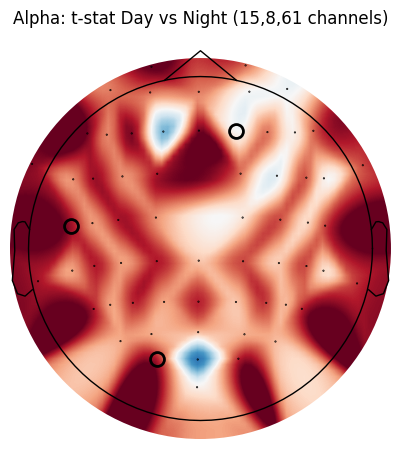

In [12]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import mne

def band_idx(freqs, lo, hi):
    return np.where((freqs >= lo) & (freqs <= hi))[0]

def band_values_for_channel(M, idx, ch):
    X = M.get(ch, np.empty((0, len(freqs))))
    return np.nanmean(X[:, idx], axis=1) if (X.size and idx.size) else np.array([])

def tmap_for_band(dayM, nightM, idx, n_channels):
    tvals = np.full(n_channels, np.nan)
    for ch in range(n_channels):
        x = band_values_for_channel(dayM, idx, ch)
        y = band_values_for_channel(nightM, idx, ch)
        if x.size >= 2 and y.size >= 2:
            t, _ = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
            tvals[ch] = t
    return tvals


lo, hi = 7, 13   # Alpha
idx = band_idx(freqs, lo, hi)

n_channels = len(eeg.info['ch_names'])
df_mask = band_df['band'] == 'Alpha'
ff_table = band_df[df_mask]
tvals = ff_table['t_stat']

vmax = np.nanmax(np.abs(tvals))
vlim = (-vmax, vmax) if np.isfinite(vmax) and vmax > 0 else (-1, 1)

mask = np.zeros(n_channels, dtype=bool)
for ch in [15, 8, 61]:
    if 0 <= ch < n_channels:
        mask[ch] = True


fig, ax = plt.subplots(1, 1, figsize=(4.8, 4.6))
im, _ = mne.viz.plot_topomap(
    tvals, eeg.info,
    axes=ax, show=False, cmap='RdBu_r', vlim=vlim,
    contours=0, sensors=True,
    mask=mask,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                     markeredgewidth=2, markeredgecolor='black')
)
ax.set_title(f'Alpha: t-stat Day vs Night (15,8,61 channels)')
plt.tight_layout()
plt.show()


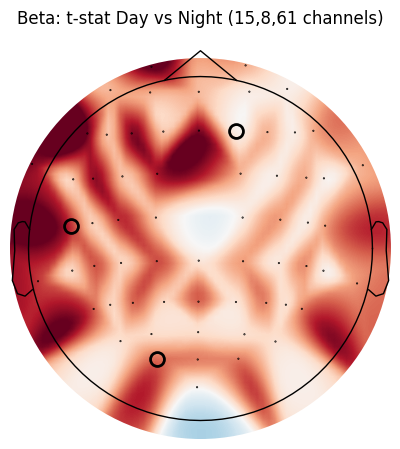

In [13]:
lo, hi = 13, 30

idx = band_idx(freqs, lo, hi)


n_channels = len(eeg.info['ch_names'])
df_mask = band_df['band'] == 'Beta'
ff_table = band_df[df_mask]
tvals = ff_table['power']


vmax = np.nanmax(np.abs(tvals))
vlim = (-vmax, vmax) if np.isfinite(vmax) and vmax > 0 else (-1, 1)


mask = np.zeros(n_channels, dtype=bool)
for ch in [15, 8, 61]:
    if 0 <= ch < n_channels:
        mask[ch] = True


fig, ax = plt.subplots(1, 1, figsize=(4.8, 4.6))
im, _ = mne.viz.plot_topomap(
    tvals, eeg.info,
    axes=ax, show=False, cmap='RdBu_r', vlim=vlim,
    contours=0, sensors=True,
    mask=mask,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                     markeredgewidth=2, markeredgecolor='black')
)
ax.set_title(f'Beta: t-stat Day vs Night (15,8,61 channels)')
plt.tight_layout()
plt.show()

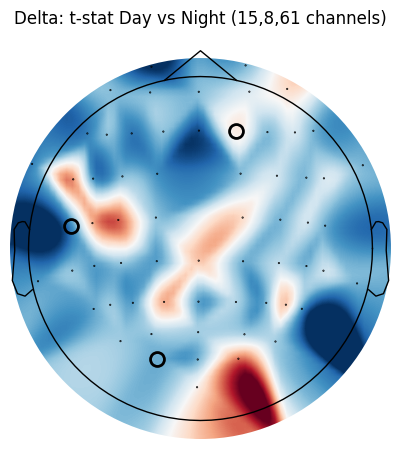

In [14]:
lo, hi = 1, 4

idx = band_idx(freqs, lo, hi)


n_channels = len(eeg.info['ch_names'])
df_mask = (band_df['band'] == 'Delta')
ff_table = band_df[df_mask]
tvals = ff_table['t_stat']


vmax = np.nanmax(np.abs(tvals))
vlim = (-vmax, vmax) if np.isfinite(vmax) and vmax > 0 else (-1, 1)


mask = np.zeros(n_channels, dtype=bool)
for ch in [15, 8, 61]:
    if 0 <= ch < n_channels:
        mask[ch] = True


fig, ax = plt.subplots(1, 1, figsize=(4.8, 4.6))
im, _ = mne.viz.plot_topomap(
    tvals, eeg.info,
    axes=ax, show=False, cmap='RdBu_r', vlim=vlim,
    contours=0, sensors=True,
    mask=mask,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                     markeredgewidth=2, markeredgecolor='black')
)
ax.set_title(f'Delta: t-stat Day vs Night (15,8,61 channels)')
plt.tight_layout()
plt.show()

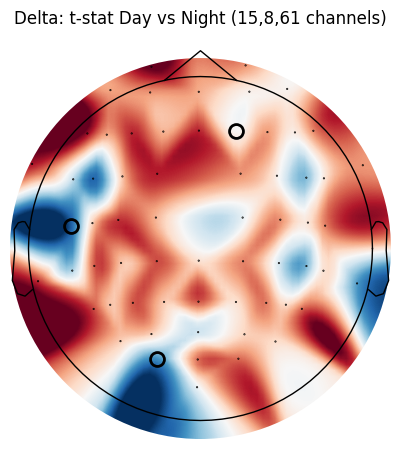

In [15]:
lo, hi = 4, 7

idx = band_idx(freqs, lo, hi)


n_channels = len(eeg.info['ch_names'])
df_mask = (band_df['band'] == 'Tetta')
ff_table = band_df[df_mask]
tvals = ff_table['t_stat']

vmax = np.nanmax(np.abs(tvals))
vlim = (-vmax, vmax) if np.isfinite(vmax) and vmax > 0 else (-1, 1)


mask = np.zeros(n_channels, dtype=bool)
for ch in [15, 8, 61]:
    if 0 <= ch < n_channels:
        mask[ch] = True


fig, ax = plt.subplots(1, 1, figsize=(4.8, 4.6))
im, _ = mne.viz.plot_topomap(
    tvals, eeg.info,
    axes=ax, show=False, cmap='RdBu_r', vlim=vlim,
    contours=0, sensors=True,
    mask=mask,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                     markeredgewidth=2, markeredgecolor='black')
)
ax.set_title(f'Delta: t-stat Day vs Night (15,8,61 channels)')
plt.tight_layout()
plt.show()

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

TARGET_CHS = [15, 8, 61]
P_THR = 0.01
POWER_THR = 0.80


wd = welch_df[welch_df['channel'].isin(TARGET_CHS)].copy()

wd = wd.replace([np.inf, -np.inf], np.nan).dropna(subset=['p_value', 'power', 't_stat', 'freq_hz'])

wd['is_sig'] = (wd['p_value'] <= P_THR) & (wd['power'] >= POWER_THR)

picks = []
for ch in TARGET_CHS:
    sub = wd[wd['channel'] == ch]
    if sub.empty: 
        continue
    sub_sig = sub[sub['is_sig']]
    best = (sub_sig if not sub_sig.empty else sub).sort_values(['p_value', 'power']).head(3)
    picks.append(best)
picks_df = pd.concat(picks, ignore_index=True) if picks else pd.DataFrame(columns=wd.columns)

print("Выбранные пики (по p, приоритет p≤0.01 & power≥0.8):")
display(picks_df[['channel','freq_hz','t_stat','p_value','power']])


Выбранные пики (по p, приоритет p≤0.01 & power≥0.8):


,channel,freq_hz,t_stat,p_value,power
0,15,25.088608,3.813698,0.001155,0.923115
1,15,25.569620,3.811613,0.001167,0.922694
2,15,24.607595,3.804396,0.001173,0.922097
3,8,40.000000,2.989581,0.007198,0.760354
4,8,39.518987,2.980719,0.007328,0.758108
5,8,39.037975,2.971132,0.007468,0.755721
6,61,23.164557,3.260263,0.004041,0.825844
7,61,23.645570,3.254755,0.004114,0.824218
8,61,22.683544,3.248236,0.004132,0.823437


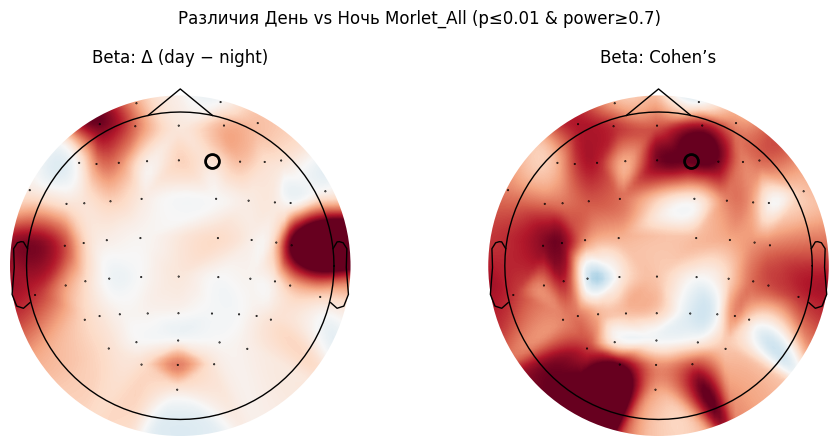

In [17]:

df_beta = band_df[band_df['band']=='Beta'].copy()   # если у тебя welch_df, подставь его

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        # маска значимости: p≤0.01 и мощность ≥0.7 
        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.7):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Beta: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Beta: Cohen’s")

plt.suptitle("Различия День vs Ночь Morlet_All (p≤0.01 & power≥0.7)")
plt.tight_layout()
plt.show()


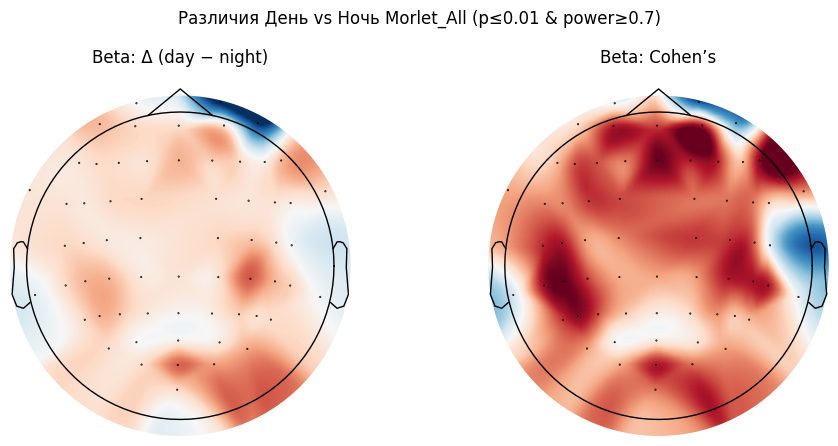

In [18]:

df_beta = band_df[band_df['band']=='Alpha'].copy()   # если у тебя welch_df, подставь его

n_channels = len(eeg.info['ch_names'])
delta_vec  = np.full(n_channels, np.nan)
d_vec      = np.full(n_channels, np.nan)
mask_sig   = np.zeros(n_channels, dtype=bool)

for _, r in df_beta.iterrows():
    ch = int(r['channel'])
    if 0 <= ch < n_channels:
        # Δ = mean_day − mean_night
        delta_vec[ch] = float(r['mean_day']) - float(r['mean_night'])

        
        # t ≈ d / sqrt(1/n1 + 1/n2)  ->  d ≈ t * sqrt(1/n1 + 1/n2)
        n1, n2 = float(r['n_day']), float(r['n_night'])
        d_vec[ch] = float(r['t_stat']) * np.sqrt(1.0/n1 + 1.0/n2)

        # маска значимости: p≤0.01 и мощность ≥0.7 (подгони под себя)
        if (float(r['p_value']) <= 0.01) and (float(r['power']) >= 0.7):
            mask_sig[ch] = True

def sym_vlim(v):
    vmax = np.nanmax(np.abs(v))
    return (-vmax, vmax) if np.isfinite(vmax) and vmax>0 else (-1,1)


fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

mne.viz.plot_topomap(
    delta_vec, eeg.info, axes=axes[0], show=False, cmap='RdBu_r',
    vlim=sym_vlim(delta_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[0].set_title("Beta: Δ (day − night)")

mne.viz.plot_topomap(
    d_vec, eeg.info, axes=axes[1], show=False, cmap='RdBu_r',
    vlim=sym_vlim(d_vec), contours=0, sensors=True,
    mask=mask_sig, mask_params=dict(marker='o', markersize=10, markerfacecolor='none',
                                    markeredgewidth=2, markeredgecolor='black')
)
axes[1].set_title("Beta: Cohen’s")

plt.suptitle("Различия День vs Ночь Morlet_All (p≤0.01 & power≥0.7)")
plt.tight_layout()
plt.show()
